#  Лабораторная работа №4. Q-обучение

## 1. Подготовительные действия

In [1]:
import sys, os
# Этот код создает виртуальный дисплей для рисования игровых изображений.
# Это не будет иметь никакого эффекта, если на вашей машине есть монитор.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    os.environ['DISPLAY'] = ':1'

import matplotlib.pyplot as plt
from collections import defaultdict
import random
import math
import numpy as np

## 2. Класс QLearningAgent

In [120]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Переменные экземпляра, к которым у вас есть доступ
        - self.epsilon (исследование)
        - self.alpha (скорость обучения)
        - self.discount (дисконт, она же гамма)
        Функции, которые вы должны использовать
        - self.get_legal_actions(state) {состояние, хешируемое -> список действий, каждое из которых
        хешируемое}
        который возвращает разрешенные действия для состояния
        - self.get_qvalue (состояние, действие)
        который возвращает Q (состояние, действие)
        - self.set_qvalue (состояние, действие, значение)
        который устанавливает Q (состояние, действие): = значение
        !!!Важно!!!
        Примечание: пожалуйста, избегайте прямого использования self._qValues.
        Для этого есть специальный self.get_qvalue/set_qvalue.
        """
        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Возвращает Q(state, action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Устанавливает Q(state, action) = value """
        self._qvalues[state][action] = value

    #---------------------ВЫ НАЧИНАЕТЕ ДОБАВЛЯТЬ СВОЙ КОД С ЭТОГО МЕСТА---------------------#
    def get_value(self, state):
        """
        Вычислите оценку вашего агента V (s), используя текущие значения q.
        V(s) = max_over_action Q(состояние,действие) по возможным действиям.
        Примечание: обратите внимание, что значения q могут быть отрицательными.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        
        # <ВАШ КОД>
        value = max([self.get_qvalue(state, action) for action in possible_actions])
        
        return value
    
    def update(self, state, action, reward, next_state):
        """
        Необходимо обновить значение Q-Value:
        Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """
        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # <ВАШ КОД>
        updated_qvalue = (1 - learning_rate) * self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state))

        self.set_qvalue(state, action, updated_qvalue)

    def get_best_action(self, state):
        """
        Вычислите наилучшее действие для состояния (используя текущие значения q).
        """
        possible_actions = self.get_legal_actions(state)
        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        
        # <ВАШ КОД>
        best_action = max(possible_actions, key=lambda action: self.get_qvalue(state, action))

        return best_action
    
    def get_action(self, state):
        """
        Вычислите действие, которое нужно предпринять в текущем состоянии, включая
        исследование.
        С вероятностью self.epsilon мы должны предпринять случайное действие.
        иначе - лучшее действие политики (self.get_best_action).
        Примечание. Чтобы выбрать случайным образом из списка, используйте random.choice(list).
        Чтобы выбрать True или False с заданной вероятностью, сгенерируйте универсальное число
        в [0, 1] и сравните с вашей вероятностью
        """
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        
        # agent parameters:
        epsilon = self.epsilon

        # <ВАШ КОД>
        if random.uniform(0, 1) < epsilon:
            chosen_action = random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)

        return chosen_action

Попробуем на среде такси. Здесь мы используем агент qlearning на такси env от openai gym. Вам нужно будет вставить сюда несколько функций агента.

In [121]:
import gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [592]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99, get_legal_actions=lambda s: range(n_actions))

def play_and_train(env, agent, t_max=10**4):
    """
    Эта функция должна
    - запустить полную игру, действия заданы политикой e-greeding агента
    - обучать агента, используя agent.update(...) всякий раз, когда это возможно
    - вернуть общую награду
    """
    total_reward = 0.0
    s = env.reset()[0]
    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)
        next_s, r, done, _, _ = env.step(a)
        # train (update) agent for state s
        agent.update(s, a, r, next_s)
        s = next_s
        total_reward += r
        if done:
            break
    return total_reward

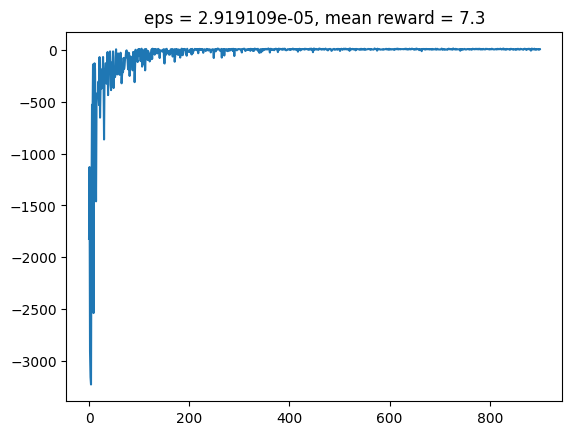

In [125]:
from IPython.display import clear_output
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

## 3. Бинаризованные пространства состояний

Используйте агент для эффективного обучения на CartPole-v0. Эта среда имеет
непрерывный набор возможных состояний, поэтому вам придется каким-то образом
сгруппировать их в бины. Самый простой способ — использовать round(x, n_digits)
(или np.round) для округления действительного числа до заданного количества цифр.
Сложность заключается в том, чтобы правильно подобрать n_digits для каждого
состояния для эффективного обучения. Обратите внимание, что вам нужно
преобразовывать состояние не в целые числа, а в кортежи любых значений.

first state: [-0.04944932 -0.00628262  0.01699755 -0.0285774 ]


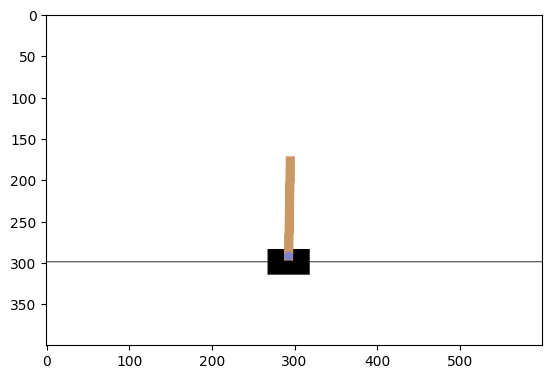

In [447]:
def make_env():
    return gym.make('CartPole-v0', render_mode="rgb_array").env # .env unwraps the TimeLimit wrapper

env = make_env()
n_actions = env.action_space.n
print("first state: %s" % (env.reset()[0]))
plt.imshow(env.render())

Нам нужно оценить распределения наблюдений. Для этого мы сыграем несколько
игр и запишем все состояния.

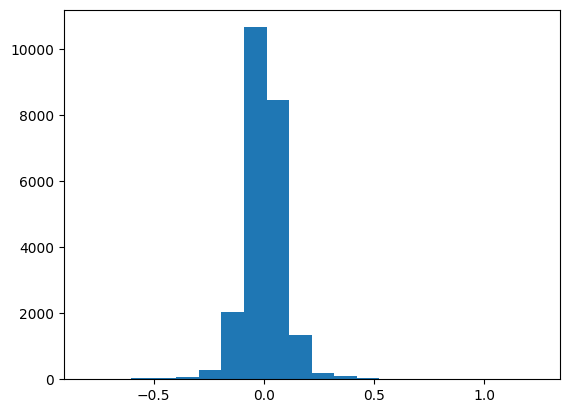

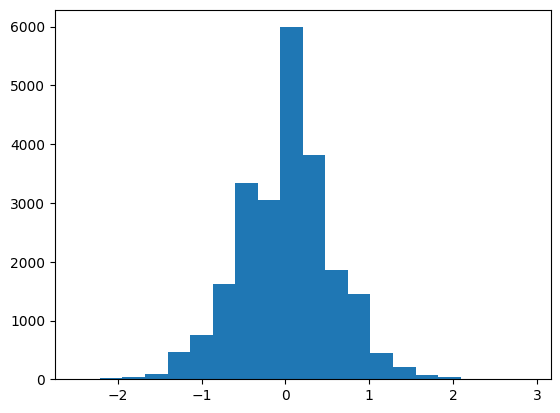

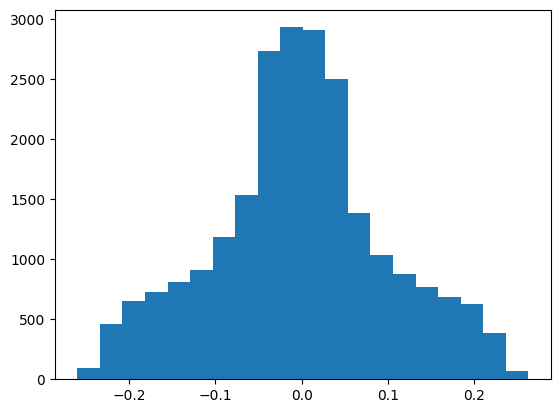

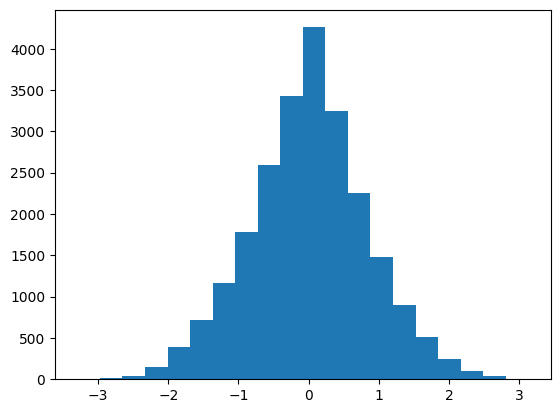

In [448]:
seen_observations = []

for _ in range(1000):
    seen_observations.append(env.reset()[0])
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

seen_observations = np.array(seen_observations)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(seen_observations[:, obs_i], bins=20)
    plt.show()

## 4. Бинаризованная среда

Требуется дополнить код. Что должен выполнять код в каждой позиции <ВАШ
КОД> указано в примечаниях к коду. 

### Данный подход не работает!

In [468]:
from gym.core import ObservationWrapper

class Binarizer(ObservationWrapper):
    def observation(self, state):
        # Hint: Используйте round(x, n_digits).
        # Вы можете выбрать разные n_digits для каждого измерения..
        state[0] = round(state[0], 0)
        state[1] = round(state[1], 1)
        state[2] = round(state[2], 2)
        state[3] = round(state[3], 1)
        return tuple(state)

Дискретизируем состояния иначе:

In [588]:
from gym.core import ObservationWrapper

class Binarizer(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.angle = 6  # Количество интервалов для Pole Angle
        self.angle_velocity = 12  # Количество интервалов для Pole Angular Velocity

    def observation(self, state):
        """
        Преобразование состояния в дискретное пространство.
        """
        # Исключим признаки Cart Position и Cart Velocity, положив в них единственное значение - 0
        state[0] = 0
        state[1] = 0

        # Pole Angle: [-0.42, 0.42] -> [0, 6]
        state[2] = min(self.angle, max(0, int((state[2] + 0.42) / 0.84 * self.angle)))

        # Pole Angular Velocity: масштабируем [-Inf, Inf] до [-4, 4], затем дискретизируем [0, 12]
        theta_vel_scaled = max(-4, min(4, state[3]))
        state[3] = min(self.angle_velocity, max(0, int((theta_vel_scaled + 4) / 8 * self.angle_velocity)))

        return tuple(state)


In [589]:
env = Binarizer(gym.make("CartPole-v0"))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [590]:
env.spec

EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


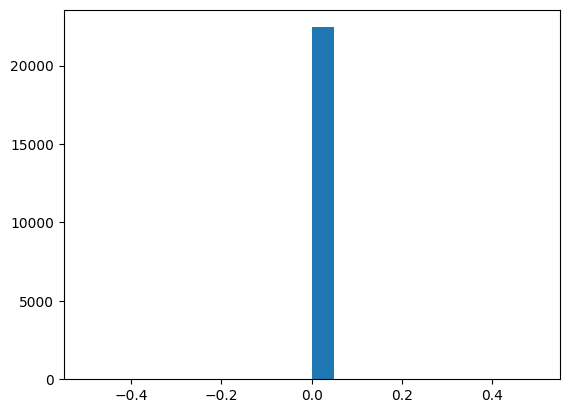

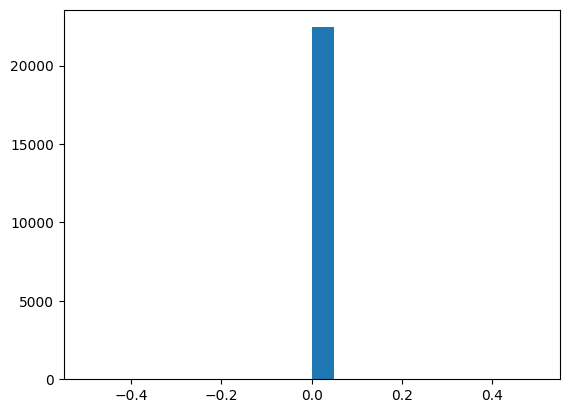

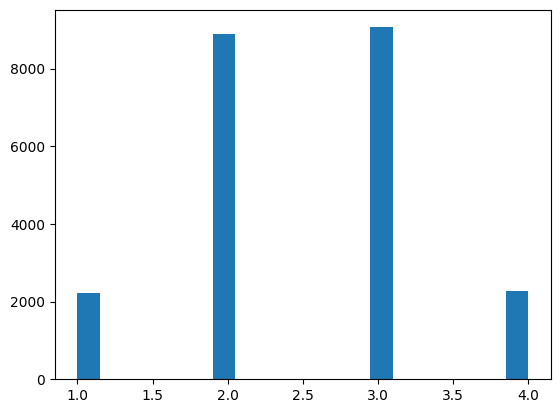

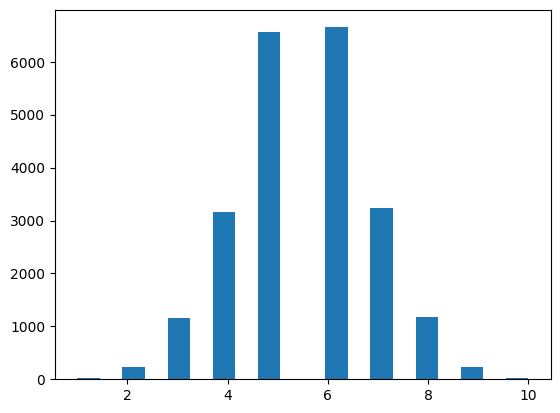

In [540]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset()[0])
    done = False
    while not done:
        s, r, done, _, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

seen_observations = np.array(seen_observations)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(seen_observations[:, obs_i], bins=20)
    plt.show()

Проверим обучение при группировке возможных состояний в бины:

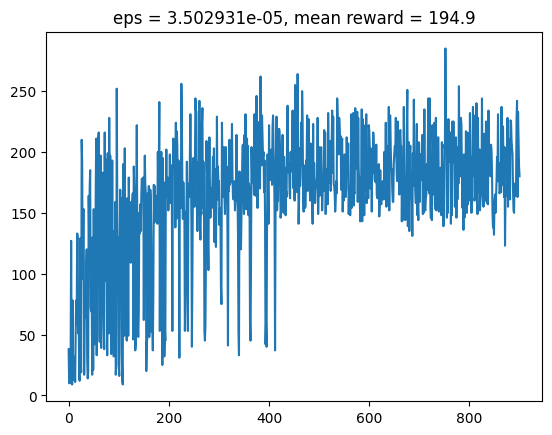

In [606]:
agent = QLearningAgent(alpha=0.5, epsilon=0.3, discount=0.99, get_legal_actions=lambda s: range(n_actions))

from IPython.display import clear_output
rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99
    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()